# IMPORT

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from tqdm import tqdm
from tqdm import trange, tqdm
import time
import matplotlib.pyplot as plt

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATASET AND TRANSFORMATION

In [2]:
path = Path.cwd()


uav_df = pd.read_csv(path / 'UAVs.csv')
cluster_df = pd.read_csv(path / 'Clusters.csv')
items_df = pd.read_csv(path / 'Items.csv')

print('UAVs:', uav_df.shape)
print('Clusters:', cluster_df.shape)
print('Items:', items_df.shape)


UAVs: (20, 5)
Clusters: (100, 5)
Items: (1000, 3)


In [3]:

uav_features = torch.tensor(uav_df[['UAV_x', 'UAV_y', 'UAV_z', 'UAV_max_weight']].values, dtype=torch.float)



cluster_xy = cluster_df[['Cluster_x', 'Cluster_y']].values
cluster_people = cluster_df['People_count'].values.reshape(-1, 1)
cluster_item = cluster_df['Required_item_id'].values.reshape(-1, 1)
cluster_zero = np.zeros((cluster_df.shape[0], 1))
cluster_features = np.hstack([cluster_xy, cluster_zero, cluster_people, cluster_item])
cluster_features = torch.tensor(cluster_features, dtype=torch.float)
num_cluster = cluster_features.size(0)
cluster_pad = torch.zeros((num_cluster, 1), dtype=cluster_features.dtype)
cluster_padded = torch.cat([cluster_features, cluster_pad], dim=1)



pad = torch.zeros((uav_features.size(0), 2), dtype=torch.float)
uav_padded = torch.cat([uav_features, pad], dim=1)


num_uav, uav_dim = uav_features.shape
num_cluster, clu_dim = cluster_features.shape

feature_dim = max(uav_dim, clu_dim)


if uav_dim < feature_dim:
    pad = torch.zeros((num_uav, feature_dim - uav_dim))
    uav_padded = torch.cat([uav_features, pad], dim=1)
else:
    uav_padded = uav_features


if clu_dim < feature_dim:
    pad = torch.zeros((num_cluster, feature_dim - clu_dim))
    cluster_padded = torch.cat([cluster_features, pad], dim=1)
else:
    cluster_padded = cluster_features

x = torch.cat([uav_padded, cluster_features] , dim=0)
print('Node feature matrix x shape:', x.shape)


Node feature matrix x shape: torch.Size([120, 5])


# GRAPH CONSTRUCTION

In [4]:
num_uav     = uav_features.size(0)
num_cluster = cluster_features.size(0)
velocity    = 15.0  # m/s

edges      = []
edge_attrs = []

for u in range(num_uav):
    pos_u = uav_features[u, :3]
    for c in range(num_cluster):
        pos_c = cluster_features[c, :3]

   
        distance = torch.norm(pos_u - pos_c)
        time     = distance / velocity

        people  = int(cluster_df.iloc[c]['People_count'])
        item_id = int(cluster_df.iloc[c]['Required_item_id'])

        item_weight     = float(
            items_df.loc[items_df['Item_ID'] == item_id, 'Item_weight_per_person'].values[0]
        )
        item_importance = float(
            items_df.loc[items_df['Item_ID'] == item_id, 'Item_importance_score'].values[0]
        )

      
        total_weight = people * item_weight

        
        edge_feature = torch.tensor(
            [distance, time, total_weight, item_importance],
            dtype=torch.float
        )

        edges.append([u, num_uav + c])
        edge_attrs.append(edge_feature)


edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_attr  = torch.stack(edge_attrs)

print('Edge index shape:', edge_index.shape)      
print('Edge attributes shape:', edge_attr.shape)  

Edge index shape: torch.Size([2, 2000])
Edge attributes shape: torch.Size([2000, 4])


In [5]:
y = torch.randint(0, num_cluster, (num_uav,), dtype=torch.long)


data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
loader = DataLoader([data], batch_size=1)

print(data)


Data(x=[120, 5], edge_index=[2, 2000], edge_attr=[2000, 4], y=[20])


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# MODEL

In [6]:
class UAVClusterGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr=None):
        x = F.sigmoid(self.conv1(x, edge_index))
        x = F.sigmoid(self.conv2(x, edge_index))
    
        uav_emb = x[:num_uav]
        return self.lin(uav_emb)

# TRAINING

In [7]:

learning_rates = [1e-2,1e-3,1e-4]
num_epochs = 200
results = {}

true_labels = torch.randint(0, num_cluster, (num_uav,), device='cpu')
y_onehot = F.one_hot(true_labels, num_classes=num_cluster).float()

for lr in learning_rates:
    print(f"\nTraining with learning rate = {lr}")
    model = UAVClusterGCN(in_channels=x.size(1), hidden_channels=64, out_channels=num_cluster)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history = []

    with tqdm(range(1, num_epochs + 1), desc=f"Training (lr={lr})", ncols=100) as pbar:
        for epoch in pbar:
            model.train()
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = F.mse_loss(out, y_onehot)
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    results[lr] = loss_history



Training with learning rate = 0.01


Training (lr=0.01): 100%|████████████████████████████| 200/200 [00:10<00:00, 18.46it/s, Loss=0.0042]



Training with learning rate = 0.001


Training (lr=0.001): 100%|███████████████████████████| 200/200 [00:11<00:00, 16.98it/s, Loss=0.0062]



Training with learning rate = 0.0001


Training (lr=0.0001): 100%|██████████████████████████| 200/200 [00:07<00:00, 28.18it/s, Loss=0.0107]


# LOSS AND METRICS

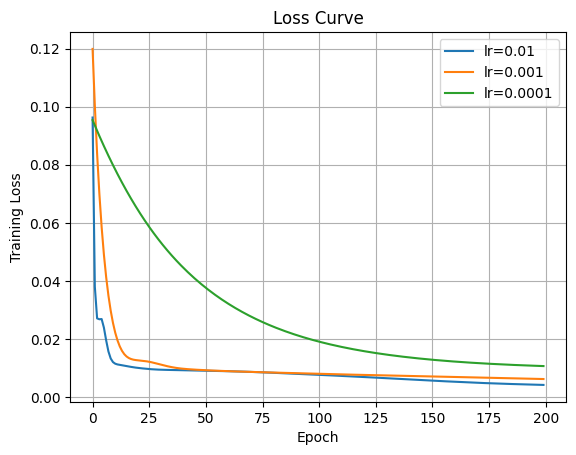

In [8]:
import matplotlib.pyplot as plt

plt.figure()
for lr, losses in results.items():
    plt.plot(losses, label=f"lr={lr}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()
